## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

#plots
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(15, 6))
import seaborn as sns

#preprocessing
import datetime as dt 
from sklearn.preprocessing import PowerTransformer


#modelling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Importing Data

In [2]:
#loading the csv file into pandas dataframe
data_data = pd.read_csv('marketing_campaign.csv', sep='\t')
data = data_data.copy()

print(f'dimensions of data: {data.shape}')

dimensions of data: (2240, 29)


In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

-> All our features are of int type except: <br>
- Education : Customer's education level
- Dt_Customer : Date of customer's enrollment with the company
- Marital Status : Customer's marital status

Missing Values

In [5]:
#we check for any missing values
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Only one feature, 'Income' has missing values


## Data Cleaning & Feature Engineering

### Redundant Features

In [6]:
data[['Z_CostContact', 'Z_Revenue']]

,Z_CostContact,Z_Revenue
0,3,11
1,3,11
2,3,11
3,3,11
4,3,11
...,...,...
2235,3,11
2236,3,11
2237,3,11
2238,3,11


These two features have the same value for each customer, thus rendering them useless. We drop these two features

In [7]:
data.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

### Customer Details

#### Time as customer of company

We look at the date on which customer enrolled with company <br> From the 'Dt_Customer' we create a new feature indicating number of days the customer has been enrolled in the database(i.e., first purchase)

In [8]:
#converting feature into date time format
data['Dt_Customer'] = (pd.to_datetime(data['Dt_Customer'], format= '%d-%m-%Y'))

#creating new feature
data['customer_since'] = (pd.Timestamp.now().normalize() - data['Dt_Customer']).dt.days

#### Marital Status

In [9]:
data['Marital_Status'].value_counts(normalize=False)

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

We reduce the cardinality of this feature by creating a new feature indicating whether the customer is in a relationship

In [10]:
def marital_function(x):

    if x['Marital_Status'] == 'Married' or x['Marital_Status'] == 'Together':
        #customer is in a relationship
        relation = True
    else:
        #customer is single
        relation = False
    return relation

#new feature
data['relation'] = data.apply(lambda x: marital_function(x), axis=1)

#### Members in household

We try to calculate the number of members in the household of the customer <br>We assume that its a nuclear family, meaning family comprises of customer, spouse (if any), children (if any)

In [11]:
data['n_child'] = data.apply(lambda x: x['Kidhome'] + x['Teenhome'], axis=1)

In [12]:
#calculating number of members in the household
def n_members(x):
    if x['Marital_Status'] == 'Married' or x['Marital_Status'] == 'Together':
        #customer+spouse+children 
        n_members = 2 + x['n_child']
    else:
        #customer + children
        n_members = 1 + x['n_child']

    return n_members

#new feature
data['n_members'] = data.apply(lambda x: n_members(x), axis=1)

#### Parent

We create a feature indicating whether the customer is a parent

In [13]:
data['is_parent'] = ((data['Kidhome'] + data['Teenhome']) > 0).astype(int)

#### Age

We look at the birth year of customers since it will influence the type of purchases

We calculate the age of customer, and divide the age feature into categories

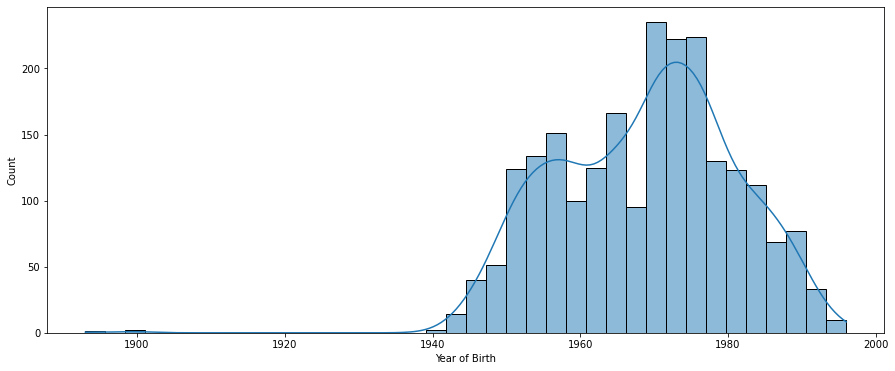

In [14]:
sns.histplot(x='Year_Birth', data=data, kde=True);
plt.xlabel('Year of Birth');

We see some outliers in the data

In [15]:
data[(data['Year_Birth'] < 1940)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,customer_since,relation,n_child,n_members,is_parent
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,0,0,0,1,0,3238,False,1,2,1
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,0,0,0,0,0,3005,False,1,2,1
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,1,0,0,0,0,3238,True,0,2,0


We have two options:<br>
1. drop these rows 
2. keep the datapoint and remove age feature 

We shall look at these outliers in the next section

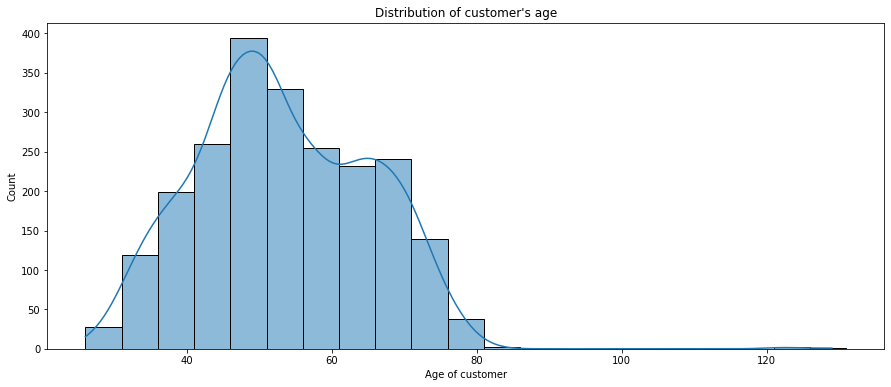

In [16]:
#new feature
data['age'] = dt.date.today().year - data['Year_Birth']

#distribution
sns.histplot(x='age', data=data, kde=True, binwidth=5)
plt.xlabel('Age of customer')
plt.title("Distribution of customer's age");

We divide the customers into categories based on age group

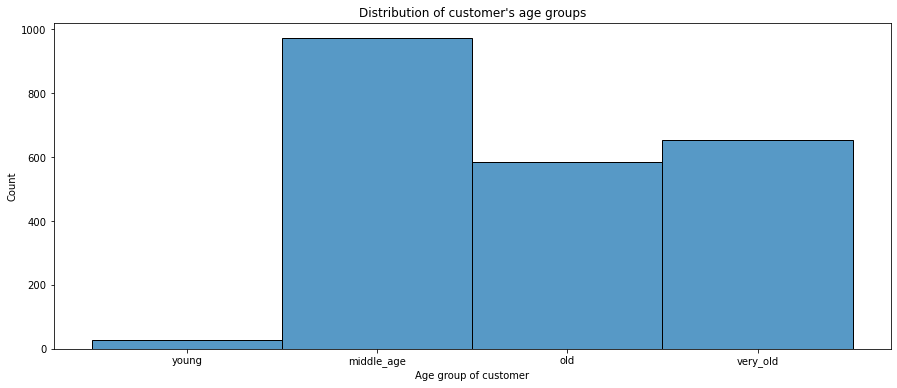

In [17]:
#categories
age_cat_labels = ['young', 'middle_age', 'old', 'very_old']
data['age_group'] = pd.cut(data['age'], bins = [15, 30, 50, 60, np.inf], labels = age_cat_labels, right = True, include_lowest = True)

#distribution
sns.histplot(x='age_group', data=data)
plt.xlabel('Age group of customer')
plt.title("Distribution of customer's age groups");

#### Income

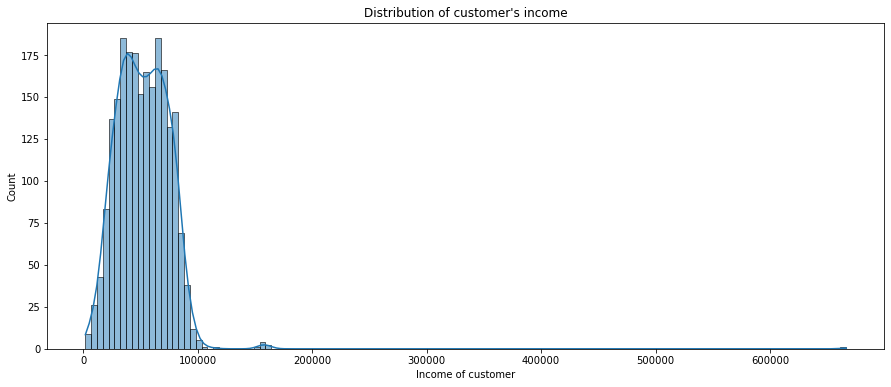

In [18]:
#income distribution among customers
sns.histplot(x='Income', data=data, kde=True)
plt.xlabel('Income of customer')
plt.title("Distribution of customer's income");

We drop the rows with missing values in Income feature

In [19]:
#dropping rows
data = data.dropna(axis=0)

We have outliers in this feature too. We choose to keep the outliers in this feature and reduce its effect by dropping the income feature

We divide the income into various categories

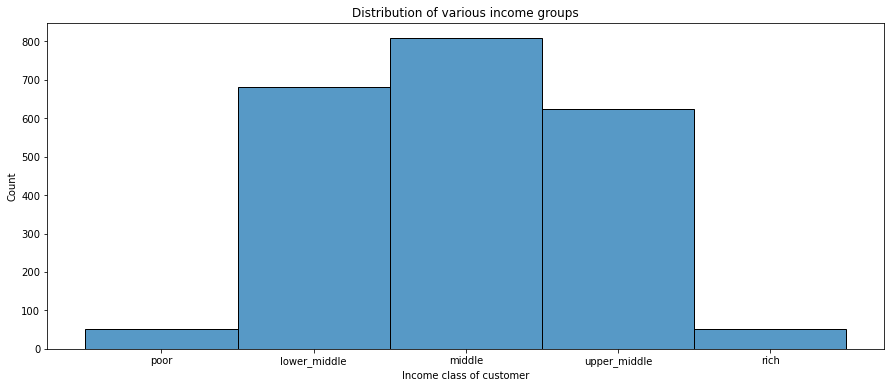

In [20]:
income_cat = ['poor', 'lower_middle', 'middle', 'upper_middle', 'rich']
data['income_group'] = pd.cut(data['Income'], bins = [0, 15000, 40000, 65000, 90000, np.inf], labels = income_cat, right = True, include_lowest = True)
#distribution
sns.histplot(x='income_group', data=data)
plt.xlabel('Income class of customer')
plt.title("Distribution of various income groups");

#### Education

In [21]:
data['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

We reduce the cardinality of this feature

In [22]:
def education_function(x):
    if x == 'Basic' or x == '2n Cycle':
        education_status = 'undergraduate'
    
    elif x == ('Graduation'):
        education_status = 'graduate'
    
    else:
        education_status = 'postgraduate'

    return education_status

data['Education'] = data.apply(lambda x: education_function(x['Education']), axis=1)

### Purchases

We look at the different purchase features to figure out spending patterns of the customer

#### Total Amount Spent

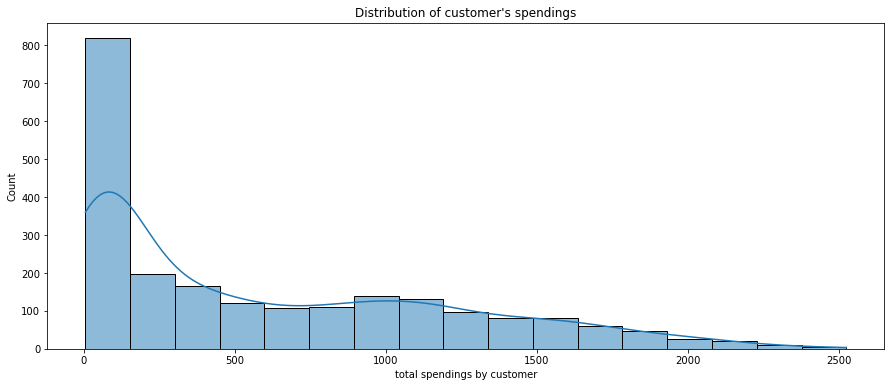

In [23]:
#total amount spent by customer in last 2 years
spend_cat = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

#total amount spent by a customer
data['total_spends'] = data[spend_cat].sum(axis=1)

#distribution
sns.histplot(x='total_spends', data=data, kde=True)
plt.xlabel('total spendings by customer')
plt.title("Distribution of customer's spendings");

In [24]:
#We check if any customer has zero spends
print('number of customers with zero spends: {}'.format((data['total_spends'] == 0).sum()))

number of customers with zero spends: 0


In [26]:
#revenue of company from different income groups
data.groupby(['income_group'])['total_spends'].sum()

income_group
poor              5387
lower_middle     63311
middle          406405
upper_middle    786583
rich             83593
Name: total_spends, dtype: int64

We see that more than 50% of the revenue earned by the company comes from upper middle class income group of customers

#### Total purchases

We calculate the total number of purchases made by the customer

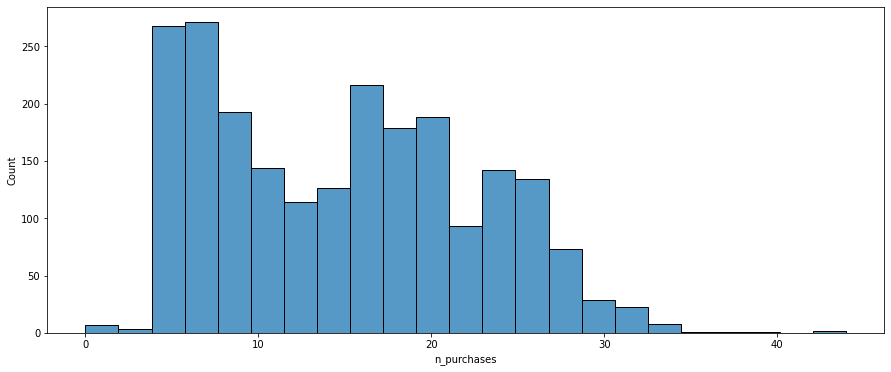

In [27]:
purchase_cat= ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']

#counting the number of purchases
data['n_purchases'] = data[purchase_cat].sum(axis=1)

#distribution
sns.histplot(x='n_purchases', data=data);

##### Zero Purchases

In [28]:
#do any customer have zero number of purchases
print('customers with zero purchases: {}'.format((data['n_purchases']==0).sum()))

customers with zero purchases: 4


Since there was no customer with zero spends, these customers have spent money. <br>
We check their total spends and replace the number of purchases with appropriate amount

In [29]:
data.loc[data['n_purchases']==0, ['total_spends']]

,total_spends
655,6
981,6
1524,5
2132,8


We see that the total amount of money spent is quite less, we assume that the number of purchases might have been 1

In [30]:
data['n_purchases'].replace(0, 1, inplace=True)

In [32]:
(data.groupby(['income_group'])['n_purchases'].sum() / data['income_group'].value_counts())

poor             8.750000
lower_middle     7.820588
middle          16.235149
upper_middle    20.886035
rich            20.320755
dtype: float64

 - We observe that poor and lower middle class customers have almost half the average number of purchases per customer compared to other income groups 

#### Mode of Purchase

##### Catalog Purchases

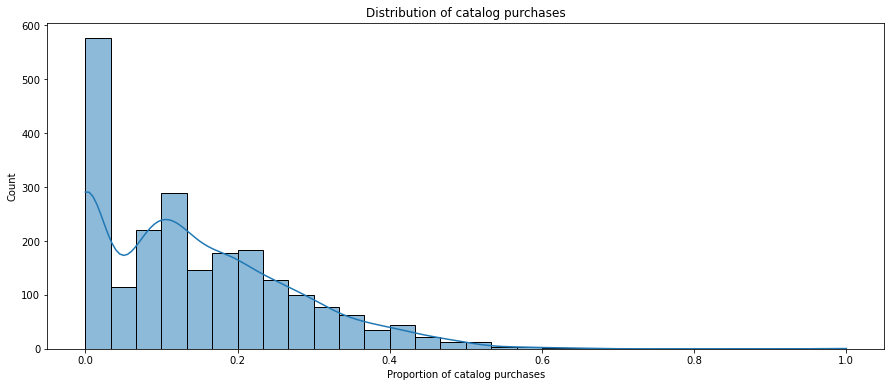

In [33]:
#new feature
data['catalog_ratio'] = data.apply(lambda x: x['NumCatalogPurchases']/x['n_purchases'], axis=1)

#distribution
sns.histplot(x='catalog_ratio', kde=True, data=data)
plt.xlabel('Proportion of catalog purchases')
plt.title("Distribution of catalog purchases");

##### Store Purchases

We create a new feature denoting the number of purchases made through store

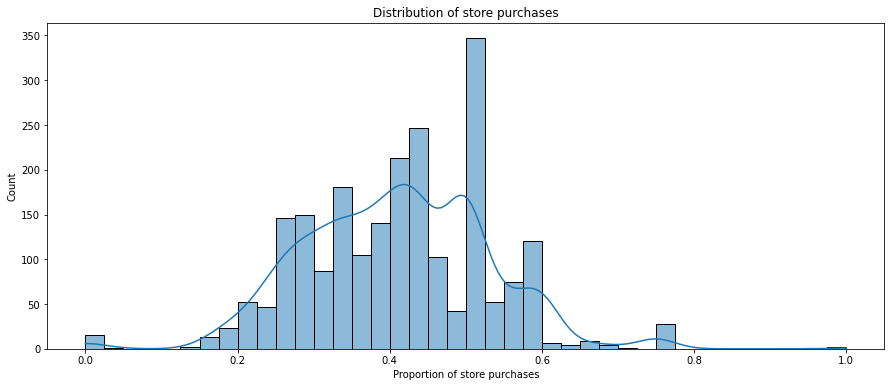

In [35]:
data['store_ratio'] = data.apply(lambda x: x['NumStorePurchases']/x['n_purchases'], axis=1)
sns.histplot(x='store_ratio', kde=True, data=data)
plt.xlabel('Proportion of store purchases')
plt.title("Distribution of store purchases");

##### Web Purchases

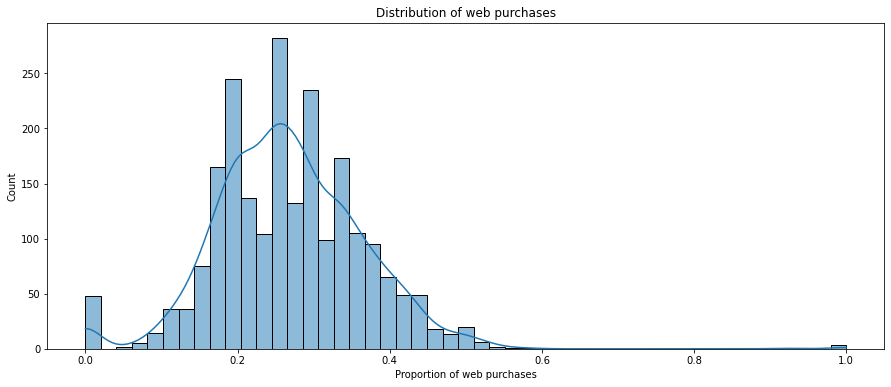

In [36]:
#new feature
data['web_ratio'] = data.apply(lambda x: x['NumWebPurchases']/x['n_purchases'], axis=1)
sns.histplot(x='web_ratio', kde=True, data=data)
plt.xlabel('Proportion of web purchases')
plt.title("Distribution of web purchases");

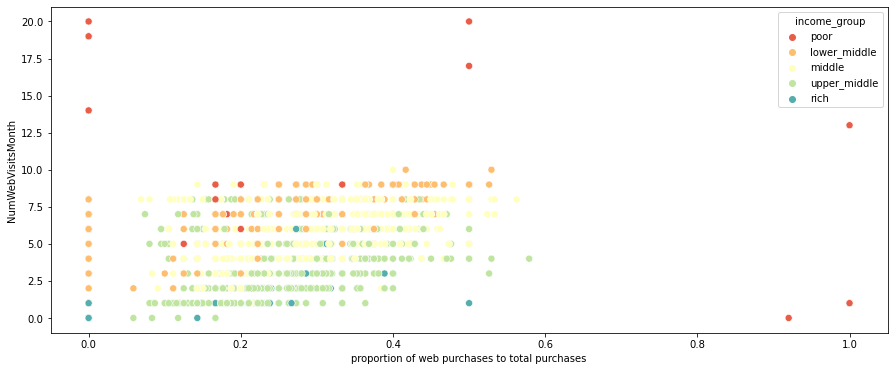

In [37]:
sns.scatterplot(x='web_ratio', y='NumWebVisitsMonth', data=data, hue='income_group', palette='Spectral', s=50);
plt.xlabel('proportion of web purchases to total purchases');

- We observe that lower income class have higher number of web visits compared to upper income classes and yet the number of web purchases made by each group is similar

##### Discount Purchases

We have a feature 'NumDealsPurchases; indicating number of purchases made with a discount <br> We create a feature denoting ratio of purchases made with discount

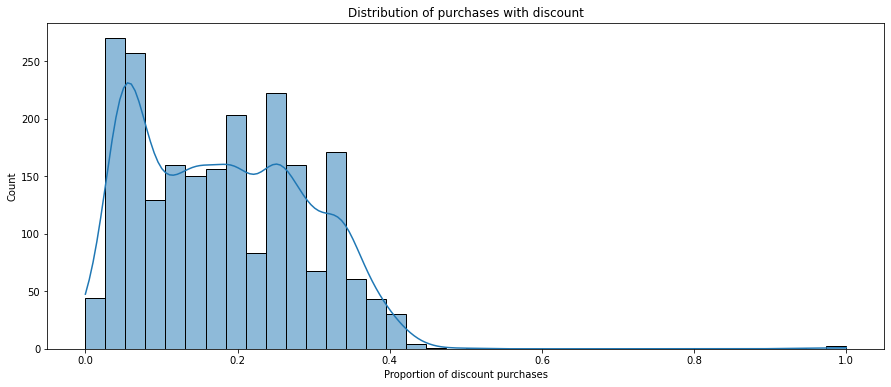

In [38]:
#new feature
data['deals_ratio'] = data.apply(lambda x: x['NumDealsPurchases']/x['n_purchases'], axis=1)

#distribution
sns.histplot(x='deals_ratio', kde=True, data=data)
plt.xlabel('Proportion of discount purchases')
plt.title("Distribution of purchases with discount");

#### Type of purchase

We look at the distribution of sales product wise

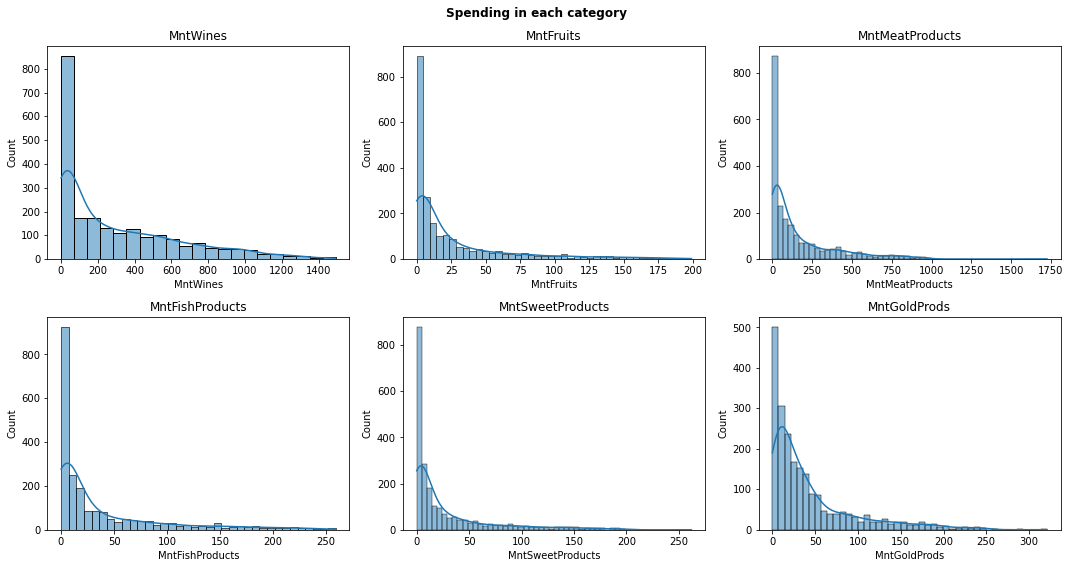

In [40]:
fig,axs = plt.subplots(2,3,figsize=(15, 8))
axs = axs.ravel()
for spend, ax in zip(spend_cat, axs):
    fig.suptitle('Spending in each category',fontweight ="bold")
    sns.histplot(data[spend], ax=ax, kde=True)
    #title of subplot
    ax.set_title(spend)
plt.tight_layout()

Insted of looking at amount spent of each category, we look at the proportion of spends in each category

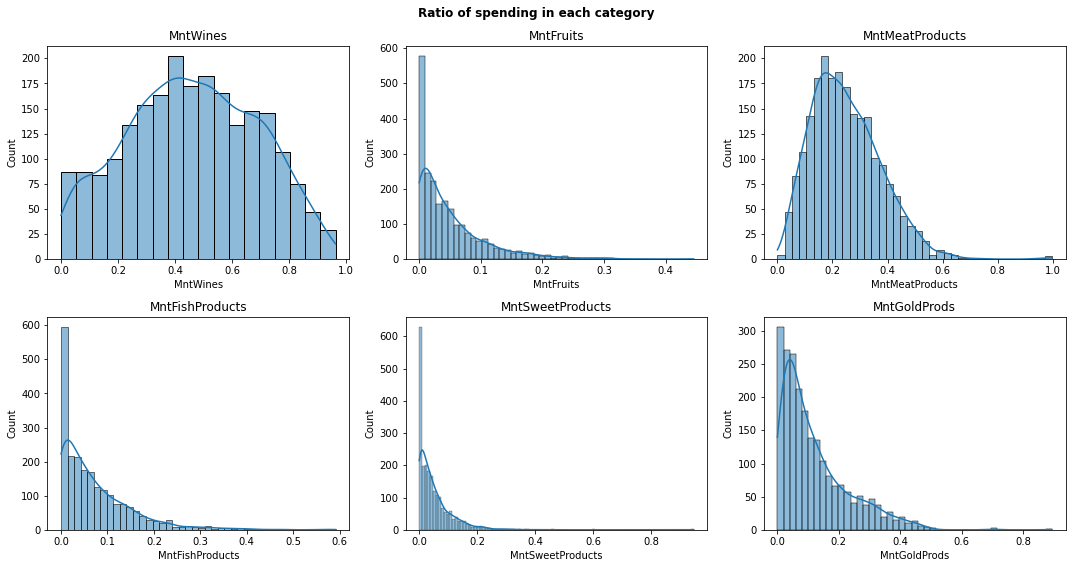

In [41]:
total_spends = data['total_spends']
for col in spend_cat:
    data[col] /= total_spends

#distribution
fig,axs = plt.subplots(2,3,figsize=(15, 8))
axs = axs.ravel()
for spend, ax in zip(spend_cat, axs):
    fig.suptitle('Ratio of spending in each category',fontweight ="bold")
    sns.histplot(data[spend], ax=ax, kde=True)
    #title of subplot
    ax.set_title(spend)
plt.tight_layout()

#### Spendings compared to Income

We calculate as to how much portion of annual income is spent by customer

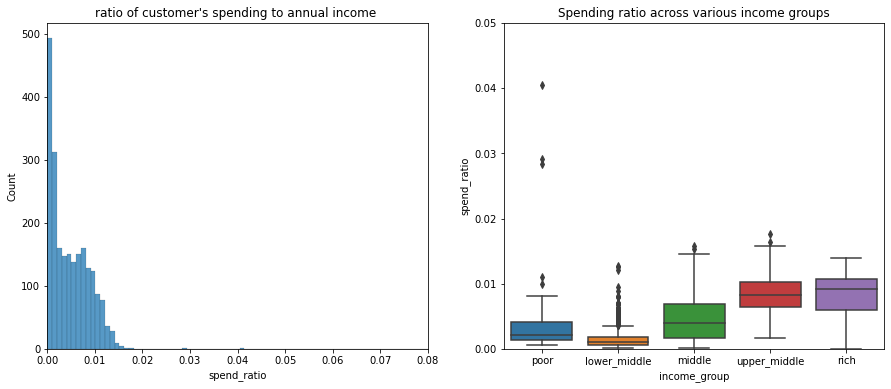

In [42]:
#creating new feature
data['spend_ratio'] = data['total_spends'] /  (2*data['Income'])

#distribution
fig,ax = plt.subplots(1,2)
ax = ax.ravel()
ax1, ax2 = ax[0], ax[1]

sns.histplot(x='spend_ratio', data=data, ax=ax1)
ax1.set_xlim([0, 0.08])
ax1.set_title("ratio of customer's spending to annual income ")

sns.boxplot(x='income_group', y='spend_ratio', data=data, ax=ax2)
ax2.set_ylim([0, 0.05])
ax2.set_title('Spending ratio across various income groups');


## Data Preprocessing

In [44]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'customer_since', 'relation',
       'n_child', 'n_members', 'is_parent', 'age', 'age_group', 'income_group',
       'total_spends', 'n_purchases', 'catalog_ratio', 'store_ratio',
       'web_ratio', 'discount_ratio', 'spend_ratio'],
      dtype='object')

In [45]:
data.select_dtypes(exclude=[int, float])

,Education,Marital_Status,Dt_Customer,relation,age_group,income_group
0,graduate,Single,2012-09-04,False,very_old,middle
1,graduate,Single,2014-03-08,False,very_old,middle
2,graduate,Together,2013-08-21,True,old,upper_middle
3,graduate,Together,2014-02-10,True,middle_age,lower_middle
4,postgraduate,Married,2014-01-19,True,middle_age,middle
...,...,...,...,...,...,...
2235,graduate,Married,2013-06-13,True,old,middle
2236,postgraduate,Together,2014-06-10,True,very_old,middle
2237,graduate,Divorced,2014-01-25,False,middle_age,middle
2238,postgraduate,Together,2014-01-24,True,very_old,upper_middle


We drop some features. These features include the ones which we feel aren't useful in clustering, and also the ones from which we already have extracted information

### Dropping Features

In [46]:
ds = data.copy()
ds.drop(
    ['Dt_Customer','Kidhome', 'Teenhome', 'ID', 'Year_Birth', 'Marital_Status', 'Income',
     'age', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    ], axis=1, inplace=True)

In [47]:
ds.columns

Index(['Education', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumWebVisitsMonth', 'Complain', 'Response', 'customer_since',
       'relation', 'n_child', 'n_members', 'is_parent', 'age_group',
       'income_group', 'total_spends', 'n_purchases', 'catalog_ratio',
       'store_ratio', 'web_ratio', 'discount_ratio', 'spend_ratio'],
      dtype='object')

### Encoding

We ordinal encode some of the categorical features

In [48]:
#encoding age group feature
ds['age_group'] = ds['age_group'].replace({'young': 1, 'middle_age': 2 , 'old': 3, 'very_old': 4}).astype(int)

#encoding Education feature
ds['Education'] = ds['Education'].replace({'undergraduate': 1, 'graduate': 2, 'postgraduate': 3}).astype(int)

#converting relation feature into int type
ds['relation'] = ds['relation'].astype(int)

#encoding income group feature
ds['income_group'] = ds['income_group'].replace({'poor': 1, 'lower_middle': 2, 'middle': 3, 'upper_middle': 4, 'rich': 5}).astype(int)

### Transformation

We shall use power transformer to reduce the skewness and scaling the data to get zero mean and unit variance 

In [49]:
transformer = PowerTransformer()
transformer.fit(ds)
scaled_ds = pd.DataFrame(transformer.transform(ds), columns=ds.columns)

## Dimensionality Reduction

We use PCA for dimensionality reduction

In [52]:
pca = PCA(n_components=3)
ds_pca = pca.fit_transform(scaled_ds)
#pca.explained_variance_ratio_

We plot our data 

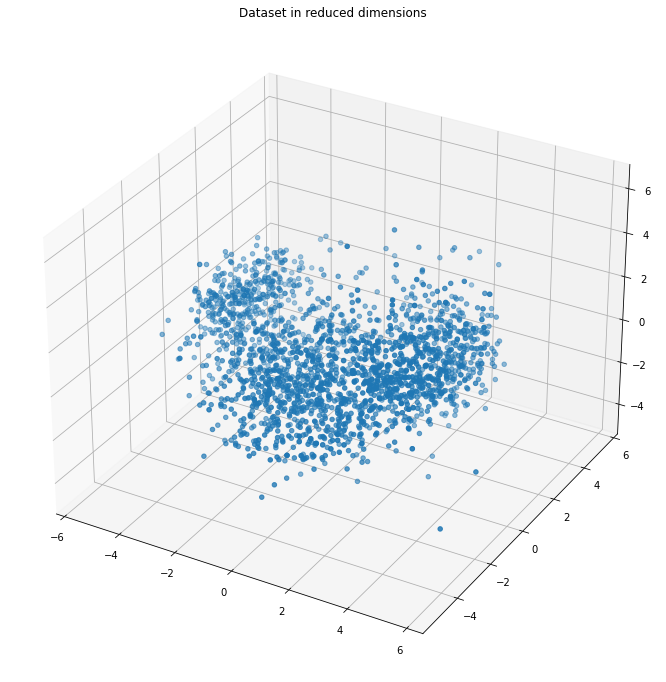

In [53]:
x = ds_pca[:, 0]
y = ds_pca[:, 1]
z = ds_pca[:, 2]

#plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.set_title('Dataset in reduced dimensions');

## Clustering

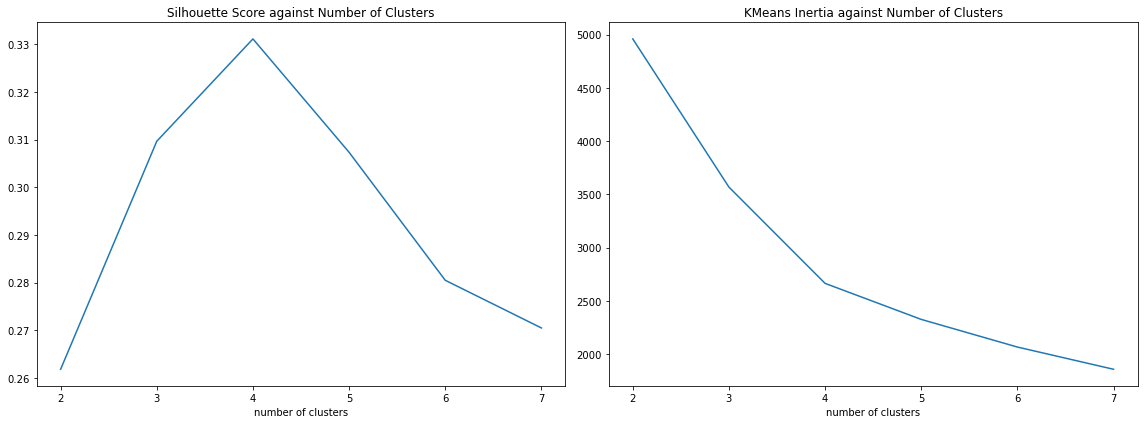

In [54]:
#we copy our data to check for optimal number of clusters
trial = ds_pca.copy()

X_scaled = trial
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

silhouette_score_list = []
inertia_list = []

for n in range(2, 8):
    kmeans = KMeans(n_clusters = n, random_state=0)
    kmeans.fit(X_scaled)
    silhouette_score_list.append(silhouette_score(X_scaled, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)

#plot
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(range(2, 8), silhouette_score_list, '-');
ax1.set_title('Silhouette Score against Number of Clusters')
ax1.set_xlabel('number of clusters')
ax2.plot(range(2, 8), inertia_list, '-')
ax2.set_title('KMeans Inertia against Number of Clusters')
ax2.set_xlabel('number of clusters')
plt.tight_layout();

From silhouette score and elbow method, we can safely take **k=4** for number of clusters

In [55]:
#clustering
X_scaled = ds_pca
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters = 4, random_state=0)
#cluster labels
labels = kmeans.fit_predict(X_scaled)

#adding cluster column to PCA reduced dataset
ds_pca = np.c_[ds_pca, labels]
#adding cluster feature to our original dataset
data['cluster'] = labels


We visualize our data after clustering

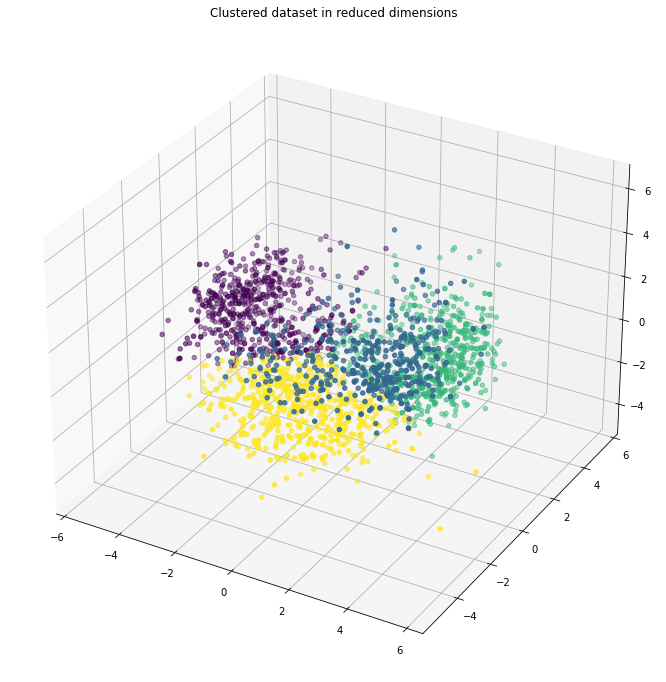

In [56]:
x = ds_pca[:, 0]
y = ds_pca[:, 1]
z = ds_pca[:, 2]

#plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=labels)
ax.set_title('Clustered dataset in reduced dimensions');

## EDA

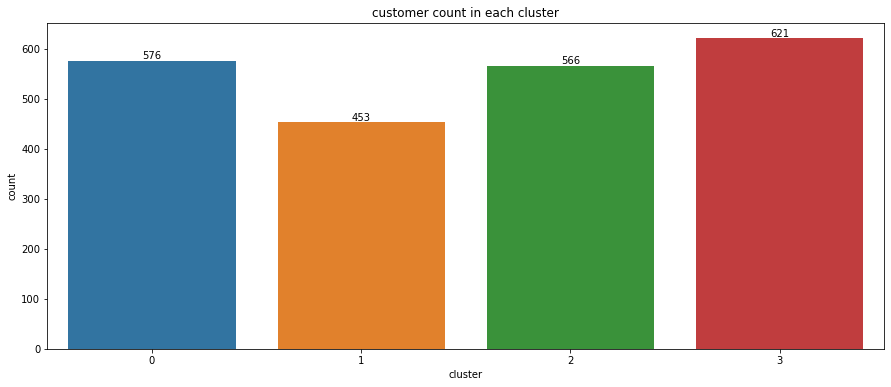

In [57]:
#distribution of customers in clusters
ax = sns.countplot(x='cluster', data=data)
for container in ax.containers:
    ax.bar_label(container, fmt = '%.0f')
ax.set_title('customer count in each cluster');

#### Income distribution

Total spendings per customer across clusters

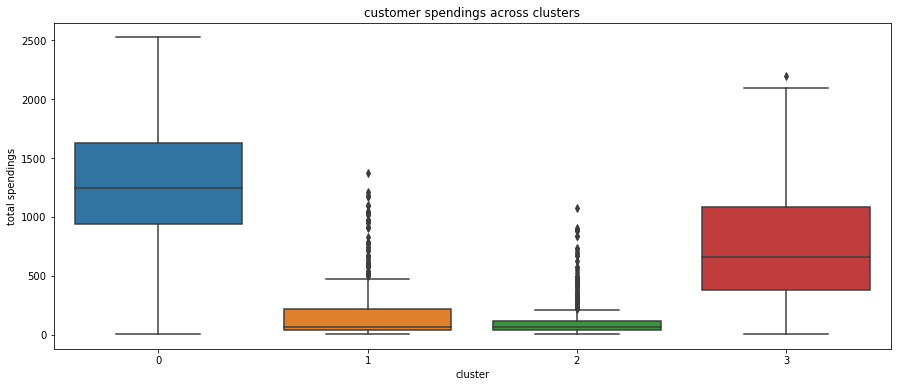

In [59]:
sns.boxplot(y='total_spends', x='cluster', data=data)
plt.title('customer spendings across clusters');
plt.ylabel('total spendings');

Average revenue per customer in each cluster

In [60]:
data.groupby(['cluster'])['total_spends'].sum() / data['cluster'].value_counts()

0    1276.397569
1     176.777042
2     113.491166
3     750.012882
dtype: float64

-> **We observe that customers in cluster 0 on average spend more than customers in other clusters combined**

#### Spending patterns

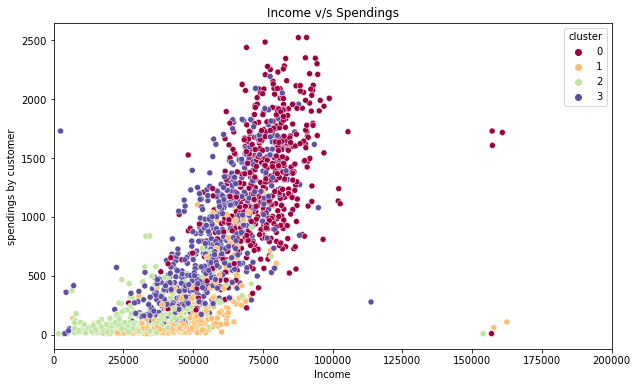

In [61]:
plt.figure(figsize=(10,6))
sns.scatterplot(y='total_spends', x='Income', hue='cluster', data=data, palette='Spectral')
plt.xlim([0, 200000])
plt.title('Income v/s Spendings')
plt.ylabel('spendings by customer');

- cluster 0: high spending & high income
- cluster 1: low spending & average income
- cluster 2: low spending & low income
- cluster 3: high spending & average income

#### Web Purchase Patterns

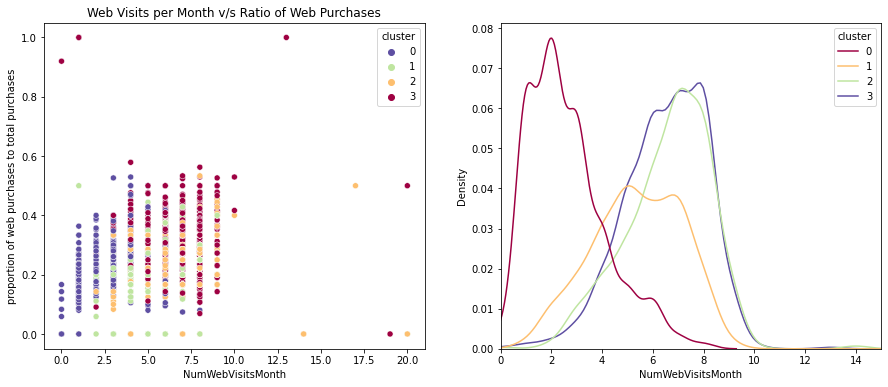

In [62]:
fig,(ax1,ax2) = plt.subplots(1,2)

sns.scatterplot(y='web_ratio', x='NumWebVisitsMonth', data=data, hue='cluster', palette='Spectral_r', ax=ax1)
ax1.set_ylabel('proportion of web purchases to total purchases')
ax1.set_title('Web Visits per Month v/s Ratio of Web Purchases')

sns.kdeplot(x='NumWebVisitsMonth', data=data, hue='cluster', palette='Spectral', ax=ax2)
ax2.set_xlim([0, 15]);

-> Web visits per month are pretty low in customers from cluster 0

#### Campaigns

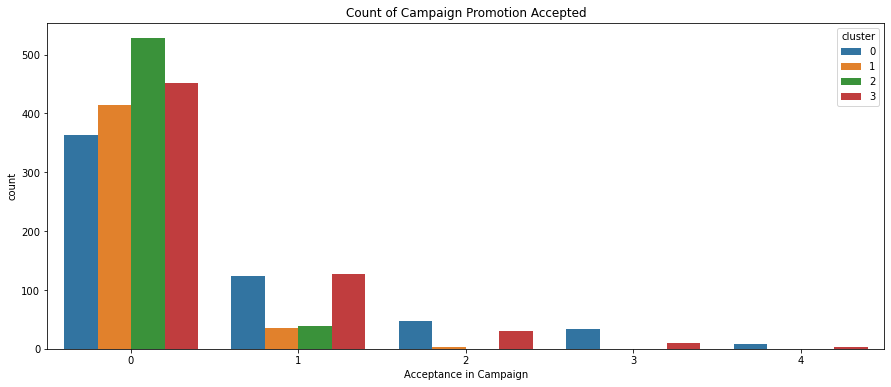

In [63]:
data['total_camp'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3']+ data['AcceptedCmp4']+ data['AcceptedCmp5']

sns.countplot(x='total_camp', hue='cluster', data=data)
plt.xlabel('Acceptance in Campaign')
plt.title('Count of Campaign Promotion Accepted');

-> Campaign 0 had been the most successful promotion so far <br>
-> Campaign 1 have gathered some interest, while other campaigns have been unsuccessful <br>
-> Except campaign 0 & 1, Clusters have 0 and 3 have responded to other campaigns, while there has been no response from other clusters <br>

## Profiling

We look at clusters through different features

In [64]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'customer_since', 'relation',
       'n_child', 'n_members', 'is_parent', 'age', 'age_group', 'income_group',
       'total_spends', 'n_purchases', 'catalog_ratio', 'store_ratio',
       'web_ratio', 'discount_ratio', 'spend_ratio', 'cluster', 'total_camp'],
      dtype='object')

### Customer Details

#### Age

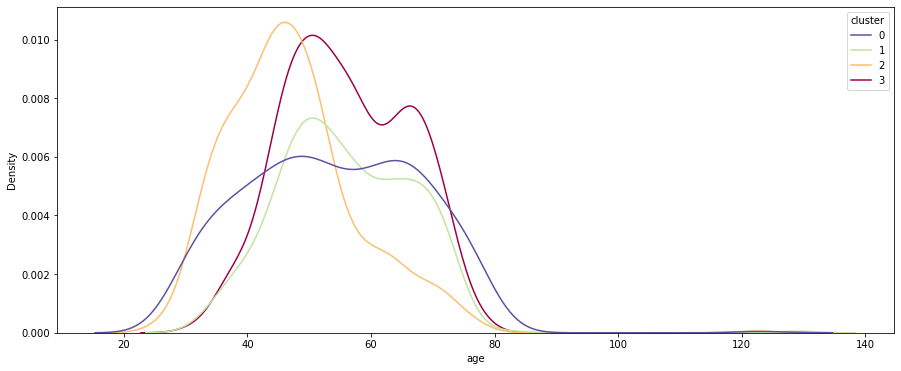

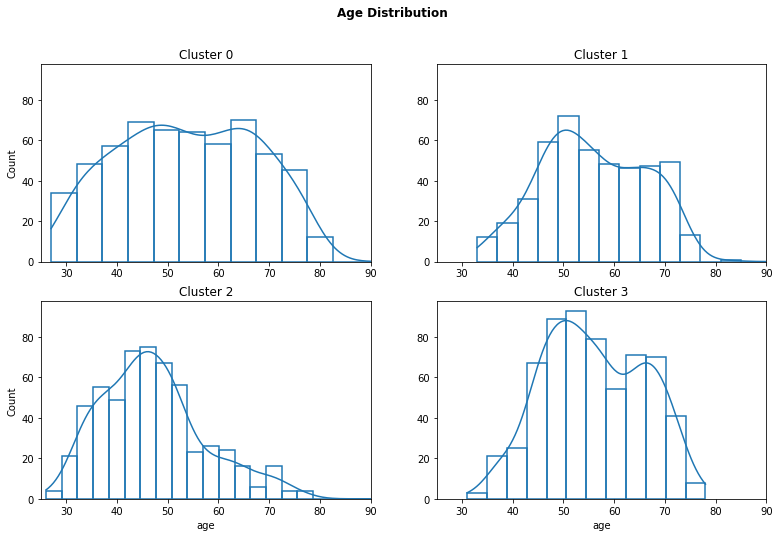

In [65]:
plt.figure()
sns.kdeplot(x='age', data=data, hue='cluster', palette='Spectral_r');


fig, (ax) = plt.subplots(2,2, figsize=(13,8), sharex=True, sharey=True)
ax = ax.ravel()
fig.suptitle('Age Distribution', fontweight='bold')

for i in range(4):
    cluster_i = data[data['cluster']==i]
    sns.histplot(x='age', data=cluster_i, ax=ax[i], kde=True, fill=False)
    ax[i].set_title(f'Cluster {i}')
    ax[i].tick_params(labelbottom=True)
    ax[i].tick_params(labelleft=True)
    ax[i].set_xlim([25, 90]);

-> Cluster 0 spans all ages <br>
-> Cluster 2 is relatively younger <br>
-> Cluster 1 & 3 have similar age distributions <br>

#### Household of customer

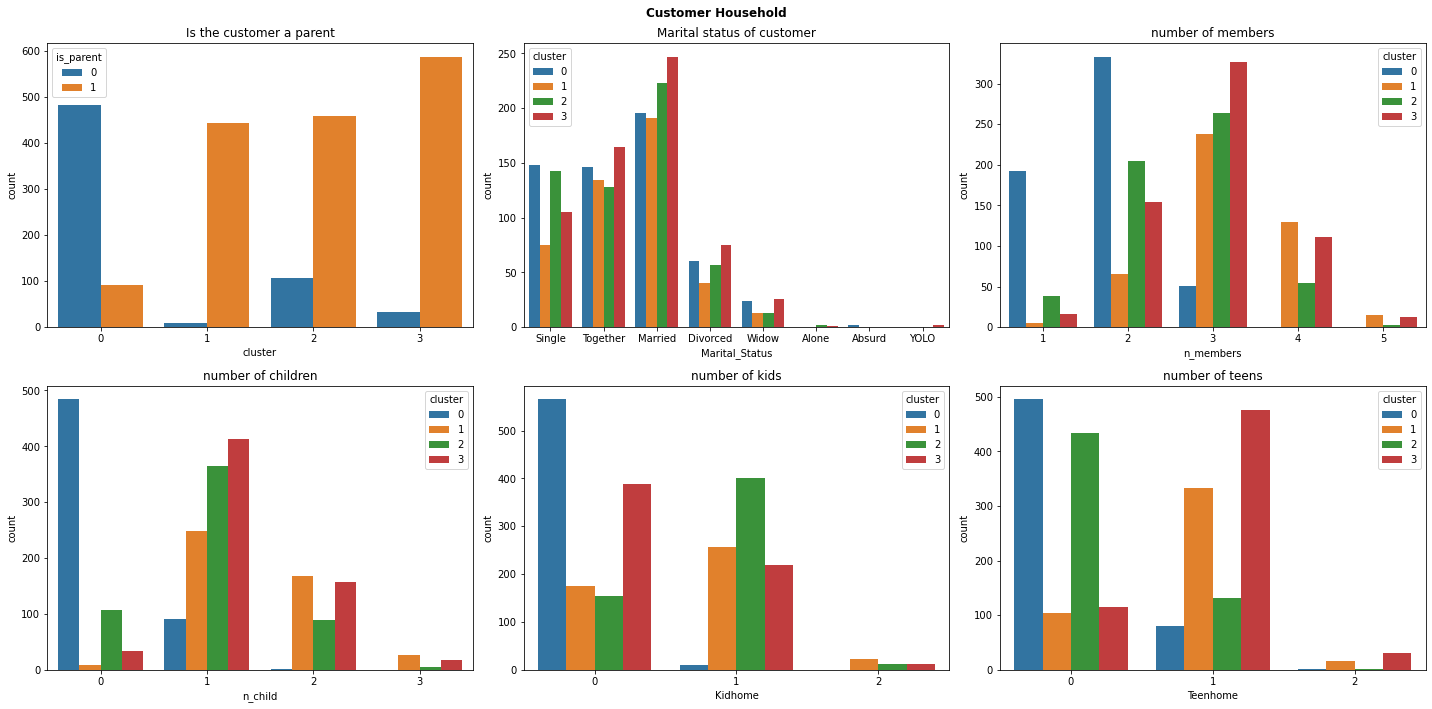

In [66]:
#subplots
fig, (ax) = plt.subplots(2,3, figsize=(20,10))
ax = ax.ravel()
fig.suptitle('Customer Household', fontweight='bold')

sns.countplot(hue='is_parent', x='cluster', data=data, ax=ax[0])
ax[0].set_title('Is the customer a parent')

#marital status of customer
sns.countplot(x='Marital_Status', hue='cluster', data=data, ax=ax[1])
ax[1].set_title('Marital status of customer')

#number of members in household
sns.countplot(x='n_members', hue='cluster', data=data, ax=ax[2])
ax[2].set_title('number of members')

#number of children in household
sns.countplot(x='n_child', hue='cluster', data=data, ax=ax[3])
ax[3].set_title('number of children')

#number of kids in household
sns.countplot(x='Kidhome', hue='cluster', data=data, ax=ax[4])
ax[4].set_title('number of kids')

#number of teens in household
sns.countplot(x='Teenhome', hue='cluster', data=data, ax=ax[5])
ax[5].set_title('number of teens')
plt.tight_layout();


-> Cluster 0: Has maximum of 2 members. Is not a parent. Single customers are subset of this cluster <br>
-> Cluster 1: Has 2-4 members. Is definitely a parent <br>
-> Cluster 2: Has a maximum of 4 members <br>
-> Cluster 3: Most likely has 2-4 members. Is definitely a parent. Single parents are subset of this cluster <br>

-> Cluster 0: Has no children <br>
-> Cluster 1: Most likely has two children at home. One kid and one teenager <br>
-> Cluster 2: Has maximum of 2 children. Has a kid at home <br>
-> Cluster 3: Most likey has 2 children. Definitely have a teenager at home <br>

In [67]:
data['relation'].value_counts(normalize=True)

True     0.645307
False    0.354693
Name: relation, dtype: float64

### Purchase Patterns

#### Sales per cluster

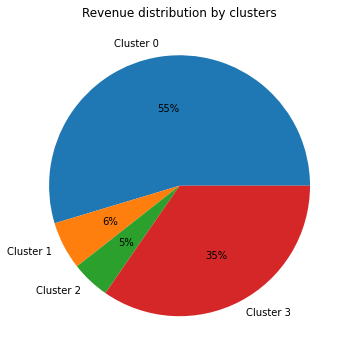

In [68]:
#calculating total revenue from each cluster
cluster_revenue = {}
for i in range(4):
    cluster_revenue[i] = data.loc[data['cluster'] == i, 'total_spends'].sum(axis=0)

#pie chart
plt.pie(cluster_revenue.values(), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], normalize=True, autopct='%0.0f%%')
plt.title('Revenue distribution by clusters');

-> The company derives 90% of their revenue from customers from cluster 0 and cluster 3 <br>
-> Total cluster spending from cluster 3 is ~10x compared to cluster 1 and cluster 2 

#### Sales across products

We look at each product and revenue distribution among cluster per product

In [69]:
data.groupby(['cluster'])[spend_cat].sum() / data[spend_cat].sum()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
cluster,,,,,,
0,0.239941,0.280395,0.342662,0.282759,0.276519,0.135655
1,0.275212,0.083103,0.175675,0.088406,0.083367,0.164220
2,0.116076,0.476828,0.260124,0.479388,0.465910,0.463595
3,0.368771,0.159674,0.221539,0.149447,0.174204,0.236530


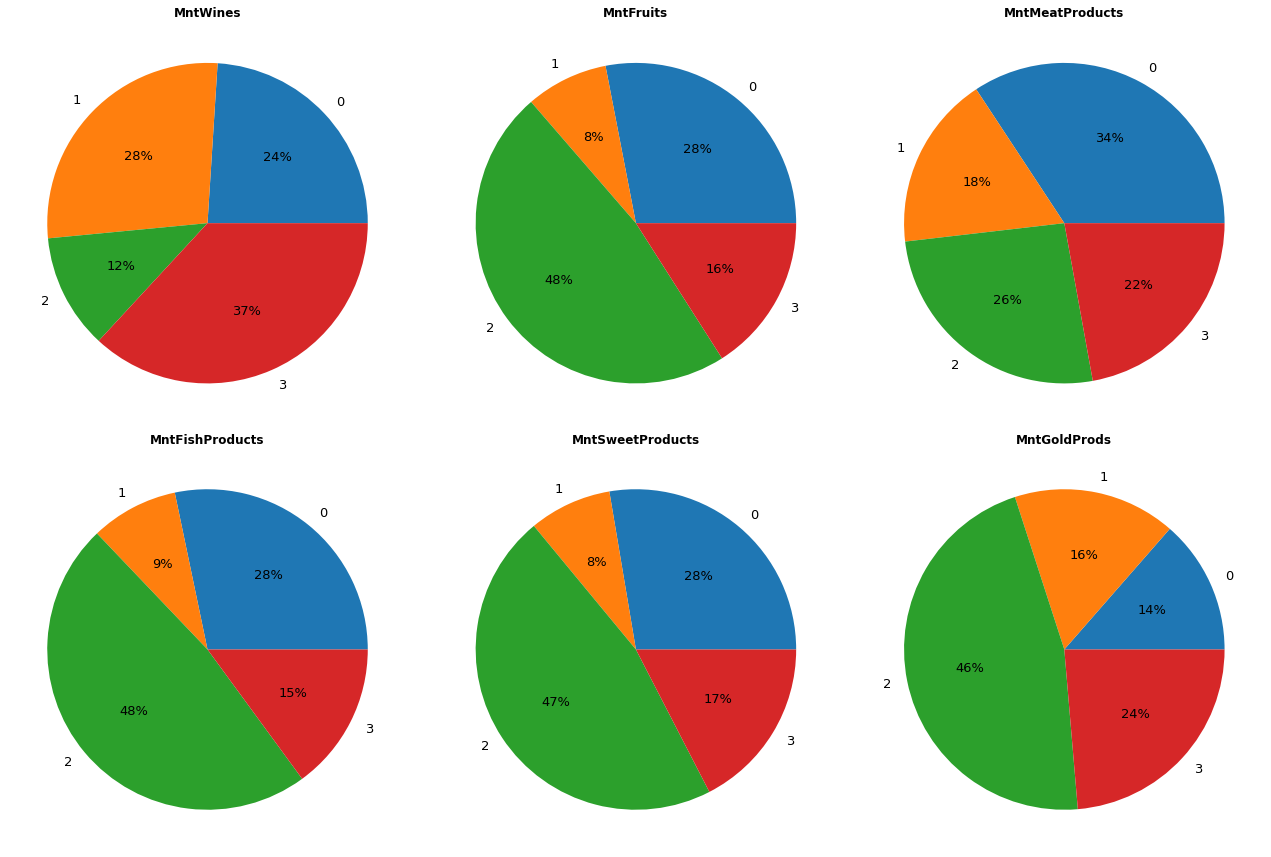

In [70]:
#pie chart for each category of product
fig,(ax) = plt.subplots(2,3, figsize=(18,12))
ax = ax.ravel()

for i, cat in enumerate(spend_cat):
    (data.groupby(['cluster'])[cat].sum() / data[cat].sum()).plot.pie(
        autopct='%0.0f%%', label='', fontsize=13, radius=1, ax=ax[i]);
    ax[i].set_title(f'{cat}', fontweight='bold')

plt.tight_layout()

-> Cluster 2 alone contributes to ~50% of sales in Fruits, Fish, Sweet and Gold segment despite being a low income group <br>
-> The distribution in other products looks even considering the uneven spending distribution

In [71]:
data.groupby(['cluster'])[spend_cat].agg('mean')

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
cluster,,,,,,
0,0.423428,0.053453,0.328355,0.078062,0.053988,0.062714
1,0.617543,0.020144,0.214049,0.031033,0.020696,0.096534
2,0.208461,0.092506,0.253667,0.134684,0.092573,0.218110
3,0.603619,0.028234,0.196906,0.038268,0.031547,0.101426


#### Cluster-wise product distribution

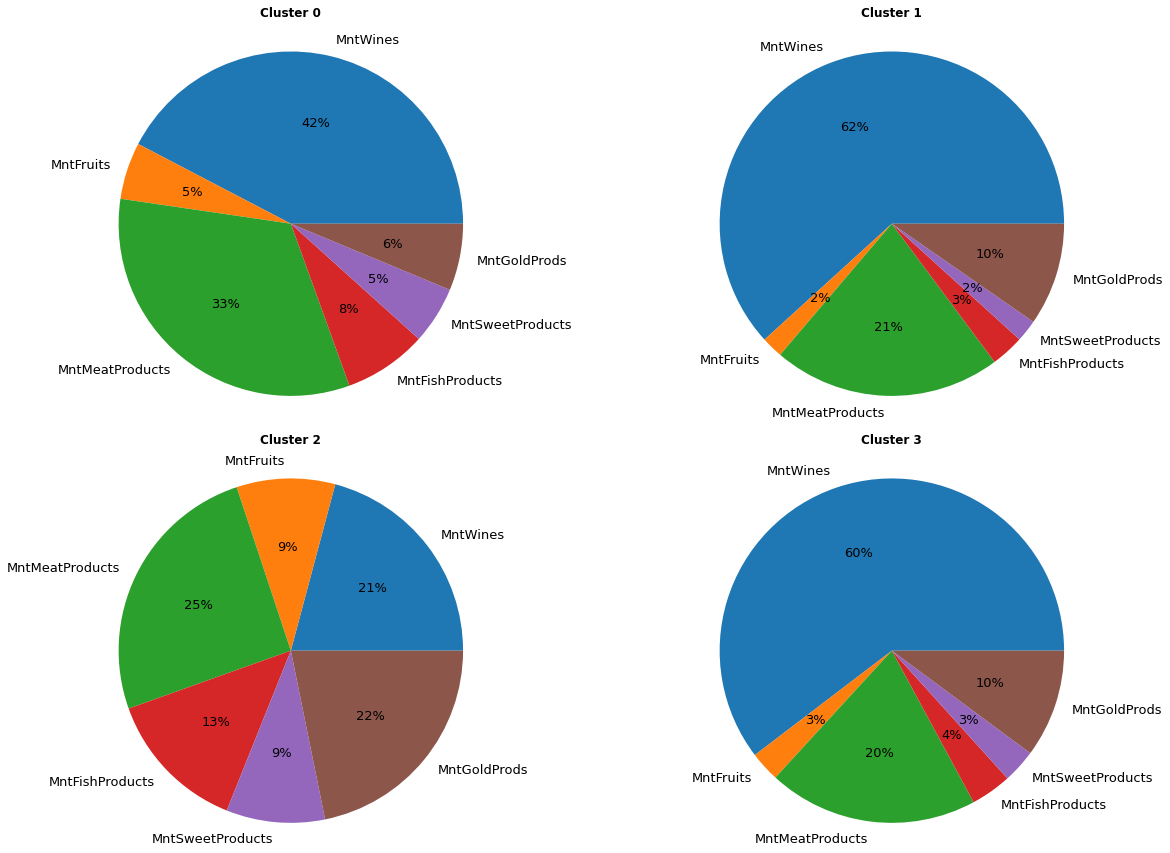

In [72]:
#pie charts for each cluster
fig,(ax) = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()

for i in range(4):
    data.loc[data['cluster'] == i, spend_cat].mean(axis=0).plot.pie(
        autopct='%0.0f%%', label='', fontsize=13, radius=1.5, ax=ax[i]);
    ax[i].set_title(f'Cluster {i}', y=1.2, fontweight='bold')

plt.tight_layout()

Cluster 0 <br>
-> 1/3rd of spending on meat <br>
Cluster 1 <br>
-> Spends heavily on wines <br>
Cluster 2 <br>
-> Pretty equal distribution among products <br>
Cluster 3 <br>
-> Spends heavily on wines <br>

#### Mode of purchase

In [73]:
purchase_mode_ratio = ['catalog_ratio', 'store_ratio', 'web_ratio', 'deals_ratio']
data.groupby(['cluster'])[purchase_mode_ratio].sum() / data[purchase_mode_ratio].sum()

,catalog_ratio,store_ratio,web_ratio,discount_ratio
cluster,,,,
0,0.505770,0.268191,0.232895,0.087394
1,0.092772,0.242520,0.174376,0.252551
2,0.107592,0.268543,0.247218,0.349394
3,0.293867,0.220745,0.345511,0.310661


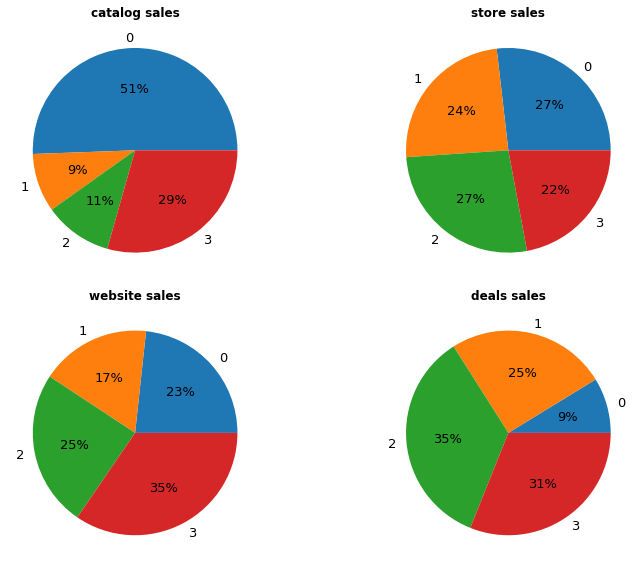

In [74]:
#pie chart for each category of product
fig,(ax) = plt.subplots(2,2, figsize=(12,8))
ax = ax.ravel()
title = ['catalog sales', 'store sales', 'website sales', 'deals sales']

for i, mode in enumerate(purchase_mode_ratio):
    (data.groupby(['cluster'])[mode].sum() / data[mode].sum()).plot.pie(
        autopct='%0.0f%%', label='', fontsize=13, radius=1, ax=ax[i]);
    ax[i].set_title(title[i], fontweight='bold')

plt.tight_layout()

-> 50% of catalog sales are from customers in cluster 0

In [75]:
data.groupby(['cluster'])[purchase_mode_ratio].agg('mean')

,catalog_ratio,store_ratio,web_ratio,discount_ratio
cluster,,,,
0,0.276622,0.422001,0.239037,0.060605
1,0.064517,0.485223,0.227571,0.222690
2,0.059885,0.430020,0.258221,0.246574
3,0.149078,0.322174,0.328925,0.199822


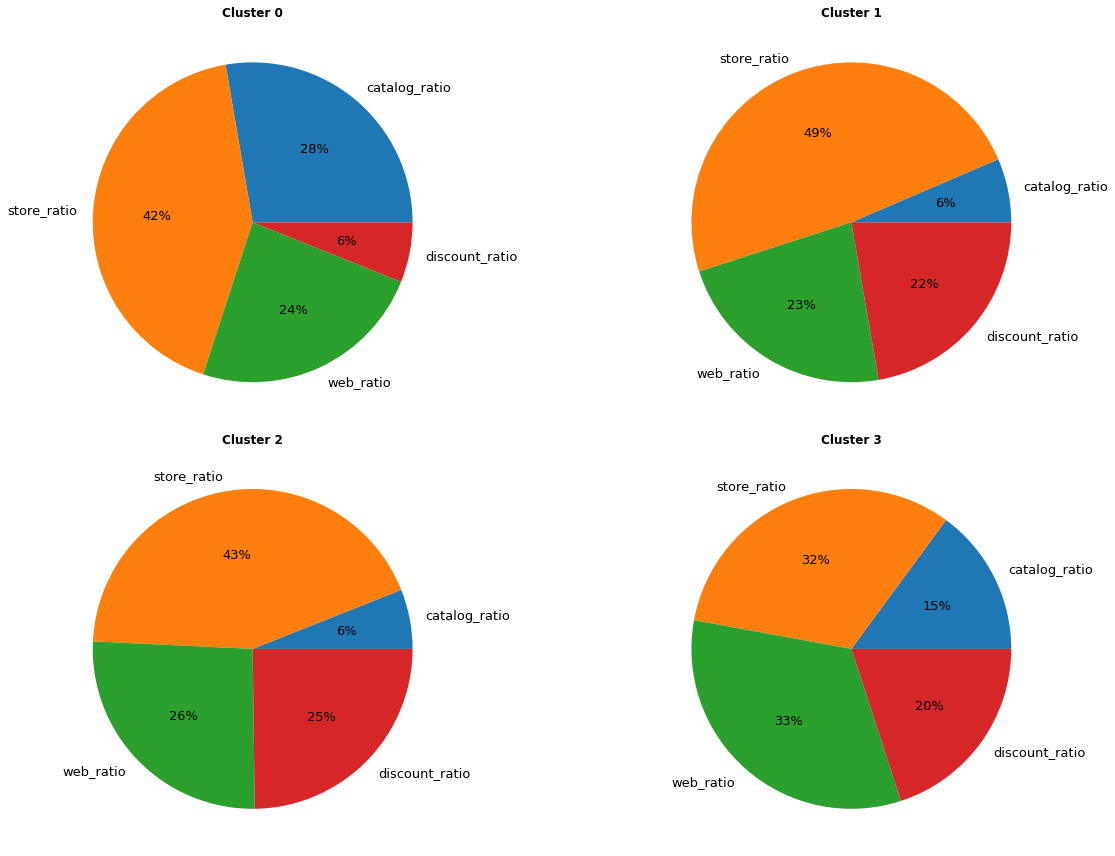

In [76]:
#pie charts for each cluster
fig,(ax) = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()

for i in range(4):
    data.loc[data['cluster'] == i, purchase_mode_ratio].mean(axis=0).plot.pie(
        autopct='%0.0f%%', label='', fontsize=13, radius=1, ax=ax[i]);
    ax[i].set_title(f'Cluster {i}', y=1, fontweight='bold')
    
plt.tight_layout()

Cluster 0 <br>
-> 30% of purchases through catalog. Number of purchases through deals are low <br>
Cluster 1 <br>
-> 50% of purchases through stores. <br>
Cluster 2 <br>
-> Has higher ratio of purchases through deals <br>
Cluster 3 <br>
-> 1/3rd purchases are through websites <br>

### Spending compared to income

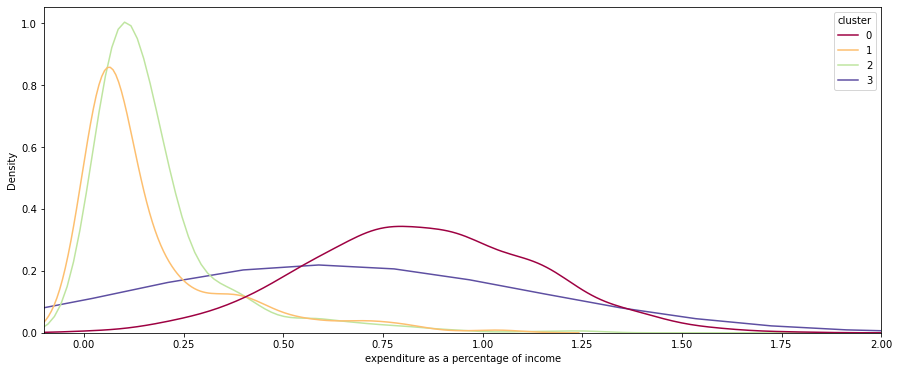

In [77]:
trial = data.copy()
trial['spend_ratio'] *= 100
sns.kdeplot(x='spend_ratio', data=trial, hue='cluster', palette='Spectral')
plt.xlim([-0.1, 2])
plt.xlabel('expenditure as a percentage of income');

-> Cluster 3 spends higher percentage of income on expenditure compared to other clusters

### Summary

#### Customer Insights

**Cluster 0**<br>
- High income group
- Spans all age groups
- Family has maximum of 2 members
- Is not a parent
- Single customers are subset of this cluster
- 1/3rd spending is on meat products
- Rarely visits the company websites
- 1/3rd purchases are through catalog
- Purchases on deals are low

**Cluster 1** 
- Family has 2-4 members
- Is definitely a parent
- Spends heavily on wines
- 50% purchases are through stores

**Cluster 2** 
- Low income group 
- Relatively younger customers
- Family has maximum of 4 members
- Equal distribution of products in their purchases
- 1/4th of purchases are with deals

**Cluster 3** 

- High income group
- Family most likely has 2-4 members
- Is definitely a parent
- Single parents are part of this cluster
- Spends heavily on wine
- 1/3rd purchases are through websites
- Spends higher percentage of income than other clusters

#### Insights for company

- ~50% of revenue is earned from cluster 0 customers
- ~90% of revenue is earned from cluster 0 and 1 customers
- Campaign 1 had been the most successful promotion so far
- Apart from campaign 1 and 2, other campaigns have been unsuccessful
- Cluster 2 alone contributes to ~50% of sales in Fruits, Fish, Sweet and Gold segment
- 50% of catalog sales are from cluster 0 customers